In [2]:
import xarray as xr
import os
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ds = xr.open_dataset('/home/clein/Documentos/archivos_jupyter/ivt_s_6_2022_Jan.nc')
df = ds.to_dataframe()
# Filtrar valores mayores a 250
df_filtered = df.loc[df['ivt'] > 250]


# Resetear el índice y agregar el número como índice al principio
df_filtered.reset_index(inplace=True)
df_filtered.index += 1

# Renombrar el nombre de la columna de índice
df = df_filtered.rename_axis("Index", axis="columns")

# Imprimir el DataFrame
print(df)

Index                  time  latitude  longitude         ivt
1       2022-01-01 00:00:00    -57.75     -54.25  251.807892
2       2022-01-01 00:00:00    -57.75     -54.00  256.242828
3       2022-01-01 00:00:00    -57.75     -53.75  256.437347
4       2022-01-01 00:00:00    -57.75     -53.50  256.694092
5       2022-01-01 00:00:00    -57.75     -53.25  254.901627
...                     ...       ...        ...         ...
2483966 2022-01-31 18:00:00     15.00     -26.00  268.630615
2483967 2022-01-31 18:00:00     15.00     -25.75  276.027283
2483968 2022-01-31 18:00:00     15.00     -25.50  281.533051
2483969 2022-01-31 18:00:00     15.00     -25.25  289.593353
2483970 2022-01-31 18:00:00     15.00     -25.00  293.868347

[2483970 rows x 4 columns]


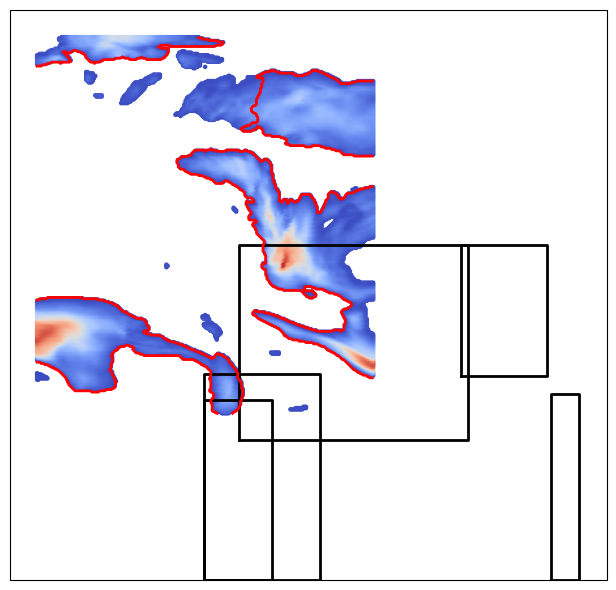

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.ndimage as ndi
from skimage import measure
import netCDF4 as nc
import cartopy.crs as ccrs

# Suponiendo que 'df' es un DataFrame que contiene los datos con columnas: 'time', 'ivt', 'latitude' y 'longitude'

# Definir la fecha específica para analizar, por ejemplo, 2022-01-01
fecha_especifica = pd.to_datetime('2022-01-01')

# Filtrar los datos correspondientes a la fecha específica
df_fecha_especifica = df[df['time'] == fecha_especifica]

# Eliminar filas con datos faltantes en las columnas 'ivt', 'latitude' o 'longitude'
df_fecha_especifica = df_fecha_especifica.dropna(subset=['ivt', 'latitude', 'longitude'])

# Obtener los valores de latitud, longitud y campo a graficar (ivt) para la fecha específica
latitudes = df_fecha_especifica['latitude']
longitudes = df_fecha_especifica['longitude']
campo_a_graficar = df_fecha_especifica['ivt']

# Crear la proyección de Placa-Carrée
projection = ccrs.PlateCarree()

# Crear una nueva figura y eje (ax) con la proyección de Placa-Carrée
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': projection})

# Graficar los datos en el mapa como un gráfico de dispersión (scatter plot)
scatter = ax.scatter(longitudes, latitudes, c=campo_a_graficar, cmap='coolwarm', s=5, transform=projection)

# Ajustar el tamaño de la figura para que se ajuste al contenido
plt.tight_layout()

# Procesar los datos para encontrar conjuntos conectados y dibujar contornos

# Reemplazar valores faltantes (NaN) por cero antes de la conversión a enteros
filled_latitudes = latitudes.fillna(0)
filled_longitudes = longitudes.fillna(0)

# Calcular el tamaño de cada píxel en grados de latitud y longitud
pixel_size = 28 / 111.0  # 1 grado de latitud/longitud ~ 111 km

# Convertir coordenadas de latitud y longitud a píxeles
lat_pixel = ((filled_latitudes - filled_latitudes.min()) / pixel_size).astype(int)
lon_pixel = ((filled_longitudes - filled_longitudes.min()) / pixel_size).astype(int)

# Crear una matriz de píxeles con etiquetas de conjuntos conectados
max_lat_pixel = lat_pixel.max()
max_lon_pixel = lon_pixel.max()
image = np.zeros((max_lat_pixel + 1, max_lon_pixel + 1), dtype=int)
image[lat_pixel, lon_pixel] = np.arange(1, len(latitudes) + 1)  # Enumerar los conjuntos (comenzando desde 1)

# Etiquetar los componentes conectados
labeled_image, num_features = ndi.label(image)

# Procesar cada conjunto conectado
conjunto_coords = []
conjunto_contornos = []
for i in range(1, num_features + 1):
    indices_conjunto_i = labeled_image == i
    contours = measure.find_contours(indices_conjunto_i.astype(int), 0.2)

    min_contour_size = 100
    for contour in contours:
        if len(contour) >= min_contour_size:
            coords = np.column_stack((contour[:, 1] * pixel_size + filled_longitudes.min(), contour[:, 0] * pixel_size + filled_latitudes.min()))  # Convertir píxeles a coordenadas de latitud y longitud
            conjunto_coords.append(coords)

            # Dibujar contorno alrededor de todo el conjunto (con huecos)
            cv2.drawContours(labeled_image, [contour.astype(int)], 0, (0, 0, 255), thickness=-1)

            # Encontrar los extremos del conjunto y dibujar un contorno alrededor de ellos
            min_lat, min_lon = np.min(coords, axis=0)
            max_lat, max_lon = np.max(coords, axis=0)
            extremos_coords = np.array([
                [min_lon, min_lat],
                [max_lon, min_lat],
                [max_lon, max_lat],
                [min_lon, max_lat],
                [min_lon, min_lat]
            ])
            ax.plot(extremos_coords[:, 0], extremos_coords[:, 1], color='black', linewidth=2, transform=projection)

# Graficar los contornos de los conjuntos conectados en el mapa
for i, coords in enumerate(conjunto_coords):
    # Dibujar contorno alrededor de todo elconjunto conectado, incluyendo los huecos
    plt.plot(coords[:, 0], coords[:, 1], color='red', linewidth=2, transform=projection)

# Guardar la figura en un archivo
plt.savefig('mapa_contornos.png')

# Mostrar el mapa
plt.show()

# Guardar el resultado en un archivo netCDF para cada conjunto conectado
for i, coords in enumerate(conjunto_coords):
    conjunto_netcdf = nc.Dataset(f'conjunto_{i+1}.nc', 'w', format='NETCDF4')

    # Crear dimensiones
    conjunto_netcdf.createDimension('lat', len(coords))
    conjunto_netcdf.createDimension('lon', 2)

    # Crear variables
    latitudes_netcdf = conjunto_netcdf.createVariable('latitudes', 'f4', ('lat',))
    longitudes_netcdf = conjunto_netcdf.createVariable('longitudes', 'f4', ('lat',))
    latitudes_netcdf[:] = coords[:, 1]
    longitudes_netcdf[:] = coords[:, 0]

    conjunto_netcdf.close()
